In [1]:
%load_ext blackcellmagic
%alias_magic -c -p "-l 120" b black

Created `%%b` as an alias for `%%black -l 120`.


# MEI Demo

In [2]:
import datajoint as dj

dj.config["enable_python_native_blobs"] = True
dj.config["schema_name"] = "nnfabrik_tutorial"

schema = dj.schema("nnfabrik_tutorial")

Connecting christoph@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306


In [3]:
import os

from matplotlib import pyplot as plt
from torch import load

from featurevis.main import TrainedEnsembleModelTemplate, CSRFV1SelectorTemplate, MEISeed, MEIMethod, MEITemplate
from nnfabrik.template import TrainedModelBase
from nnfabrik.main import Dataset

## 1. Define Tables

In [4]:
@schema
class TrainedModel(TrainedModelBase):
    pass


@schema
class TrainedEnsembleModel(TrainedEnsembleModelTemplate):
    dataset_table = Dataset
    trained_model_table = TrainedModel


@schema
class CSRFV1Selector(CSRFV1SelectorTemplate):
    dataset_table = Dataset


@schema
class MEI(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = CSRFV1Selector

## 2. Reset Tables For Demo

In [13]:
CSRFV1Selector().drop()
TrainedEnsembleModel().drop()
MEIMethod().drop()
MEISeed().drop()

`nnfabrik_tutorial`.`__c_s_r_f_v1_selector` (28 tuples)
`nnfabrik_tutorial`.`__m_e_i` (1 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.
`nnfabrik_tutorial`.`trained_ensemble_model` (1 tuples)
`nnfabrik_tutorial`.`trained_ensemble_model__member` (2 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.
`nnfabrik_tutorial`.`#m_e_i_method` (1 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.
`nnfabrik_tutorial`.`#m_e_i_seed` (1 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


## 3. Create Ensemble Model

In [5]:
TrainedEnsembleModel().create_ensemble(dict(dataset_fn="csrf_v1", dataset_hash="3d94500a46b792bbb480aedfc30f9753"), comment="Happy little ensemble")
TrainedEnsembleModel()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,ensemble_comment a short comment describing the ensemble
csrf_v1,3d94500a46b792bbb480aedfc30f9753,bd42401406ec0db224849255505fa17d,Happy little ensemble


## 4. Populate Selector Table

In [6]:
CSRFV1Selector.populate()
CSRFV1Selector()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,neuron_id unique neuron identifier,neuron_position integer position of the neuron in the model's output,session_id unique session identifier
csrf_v1,3d94500a46b792bbb480aedfc30f9753,188,0,3638456653849
csrf_v1,3d94500a46b792bbb480aedfc30f9753,189,1,3638456653849
csrf_v1,3d94500a46b792bbb480aedfc30f9753,371,0,3634744023164
csrf_v1,3d94500a46b792bbb480aedfc30f9753,372,1,3634744023164
csrf_v1,3d94500a46b792bbb480aedfc30f9753,373,2,3634744023164
csrf_v1,3d94500a46b792bbb480aedfc30f9753,374,3,3634744023164
csrf_v1,3d94500a46b792bbb480aedfc30f9753,375,4,3634744023164
csrf_v1,3d94500a46b792bbb480aedfc30f9753,376,5,3634744023164
csrf_v1,3d94500a46b792bbb480aedfc30f9753,377,6,3634744023164
csrf_v1,3d94500a46b792bbb480aedfc30f9753,378,7,3634744023164


## 5. Specify MEI Method Parameters

In [7]:
method_fn = "featurevis.methods.gradient_ascent"
method_config = dict(
    initial=dict(path="featurevis.initial.RandomNormal"),
    optimizer=dict(path="torch.optim.SGD", kwargs=dict(lr=0.1)),
    stopper=dict(path="featurevis.stoppers.NumIterations", kwargs=dict(num_iterations=1000)),
    objectives=[dict(path="featurevis.objectives.EvaluationObjective", kwargs=dict(interval=10))],
    device="cuda",
)
MEIMethod().add_method(method_fn, method_config, comment="My MEI method")
MEIMethod()

method_fn name of the method function,method_hash hash of the method config,method_config method configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the method
featurevis.methods.gradient_ascent,37237b299bbe7416541cbab11d4a4ee4,=BLOB=,2020-05-22 15:28:11,My MEI method


## 6. Add Seed

In [8]:
MEISeed().insert1(dict(mei_seed=42))
MEISeed()

mei_seed MEI seed
42


## 7. Generate MEIs

In [9]:
MEI().populate(dict(neuron_id=188), display_progress=True)
MEI()

100%|██████████| 1/1 [00:09<00:00,  9.27s/it]


method_fn name of the method function,method_hash hash of the method config,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,neuron_id unique neuron identifier,mei_seed MEI seed,mei the MEI as a tensor,score some score depending on the used method function,output object returned by the method function
featurevis.methods.gradient_ascent,37237b299bbe7416541cbab11d4a4ee4,csrf_v1,3d94500a46b792bbb480aedfc30f9753,bd42401406ec0db224849255505fa17d,188,42,=BLOB=,3.51542,=BLOB=


## 8. Look at MEIs

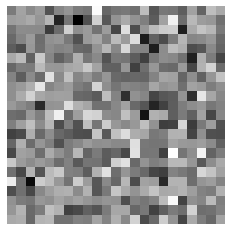

In [12]:
neuron_id = 188
mei_path = (MEI() & dict(ensemble_hash=0, neuron_id=neuron_id)).fetch1("mei")
plt.imshow(load(mei_path).squeeze(), cmap="gray")
plt.gca().axis("off")
os.remove(mei_path)

## 9. Plot Evaluations Across Time

Text(0, 0.5, 'evaluation')

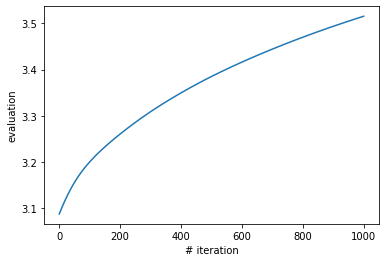

In [11]:
output_path = (MEI() & dict(ensemble_id=0, neuron_id=neuron_id)).fetch1("output")
output = load(output_path)
os.remove(output_path)

plt.plot(
    output["featurevis.objectives.EvaluationObjective"]["times"],
    output["featurevis.objectives.EvaluationObjective"]["values"],
)
plt.gca().set_xlabel("# iteration")
plt.gca().set_ylabel("evaluation")